In [4]:
import os
import random
from collections import Counter
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data._utils.collate import default_collate
from torch.optim import AdamW
from torchvision import transforms
from transformers import (
    VideoMAEImageProcessor,
    AutoConfig,
    AutoModelForVideoClassification,
    get_scheduler
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

C:\Users\jet\AppData\Local\Temp\ipykernel_14936\3666533187.py:47: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),


Размер датасета: 34023
Пакет 1:
  Метки: tensor([2, 1, 1, 1, 2, 2, 1, 1])
  Форма батча: torch.Size([8, 1, 8, 3, 224, 224])
    Пример 1: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 2: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 3: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 4: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 5: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 6: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 7: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 8: Форма входных данных: torch.Size([1, 8, 3, 224, 224])


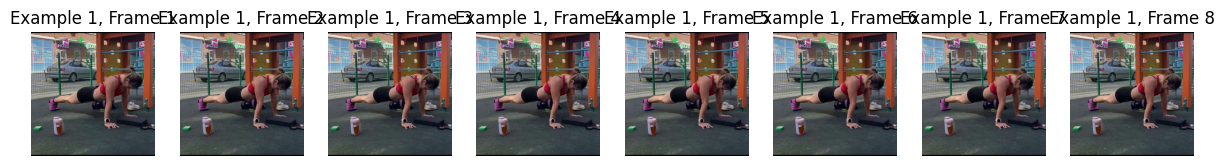

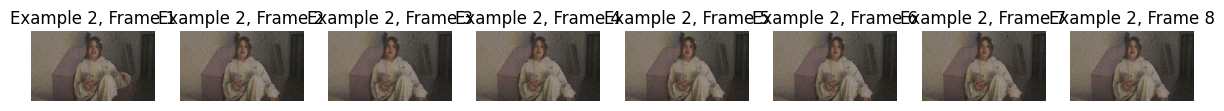

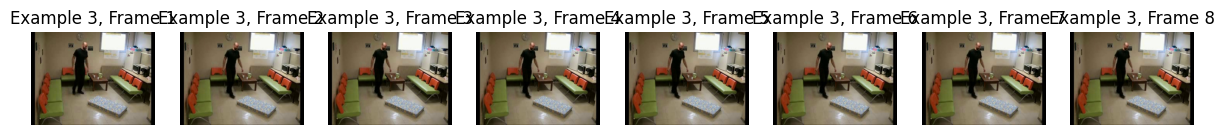

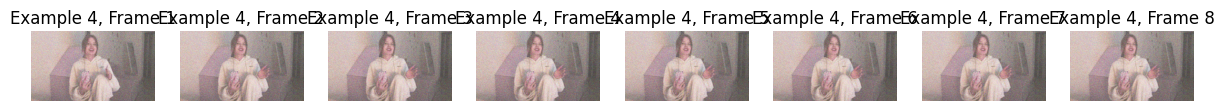

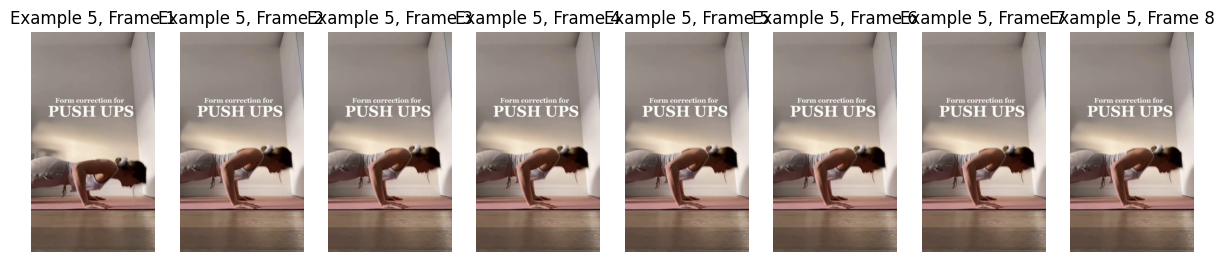

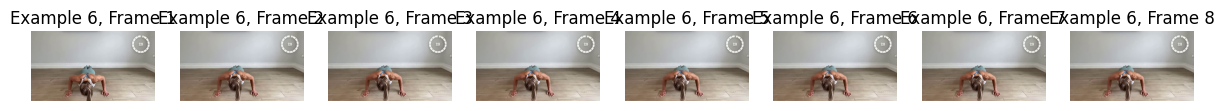

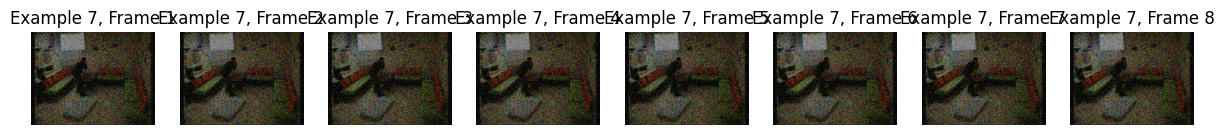

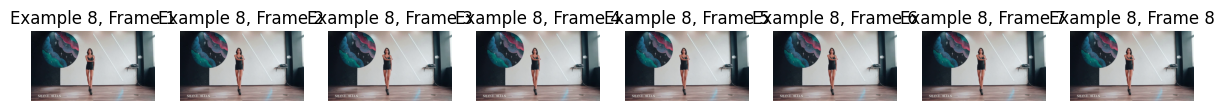


KeyboardInterrupt


KeyboardInterrupt



In [6]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, model_name, max_frames=8, transform=None, stride_options=[2,4,5,6]):
        """
        root_dir: корневая папка с данными, где каждая подпапка соответствует классу
        model_name: имя модели для загрузки предобученного VideoMAEImageProcessor
        max_frames: количество кадров, подаваемых в модель (будут выбраны кадры с определённым шагом)
        transform: преобразования для каждого кадра
        stride_options: список вариантов шага для выборки кадров (например, [4,5,6])
        """
        self.root_dir = root_dir
        self.model_name = model_name
        self.max_frames = max_frames
        self.transform = transform
        self.stride_options = stride_options

        self.video_files = []
        self.video_labels = []
        classes_set = set()

        # Рекурсивно обходим директории и ищем видеофайлы
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
                    video_path = os.path.join(root, file)
                    # Класс определяется по имени родительской директории
                    class_name = os.path.basename(os.path.dirname(video_path))
                    self.video_files.append(video_path)
                    self.video_labels.append(class_name)
                    classes_set.add(class_name)

        if not self.video_files:
            print("Предупреждение: Датасет пустой. Проверьте, что путь к данным корректен и файлы существуют.")

        # Преобразование меток: имя класса -> числовой индекс
        self.class_names = sorted(list(classes_set))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.video_labels = [self.class_to_idx[label] for label in self.video_labels]

        # Инициализируем предобученный процессор для извлечения признаков
        self.feature_extractor = VideoMAEImageProcessor.from_pretrained(self.model_name)

        # Определяем аугментацию с использованием Albumentations
        additional_targets = {f"image{i}": "image" for i in range(1, self.max_frames)}
        self.augment = A.Compose(
            [
                A.GaussianBlur(blur_limit=(3, 7), p=1.0),
                A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=1.0)
            ],
            additional_targets=additional_targets
        )

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        label = self.video_labels[idx]
        try:
            cap = cv2.VideoCapture(video_path)
            frames = []
            frame_index = 0
            # Выбираем случайный шаг из заданных вариантов для данного видео
            stride = random.choice(self.stride_options)
            # Считываем видео полностью, выбирая кадры с шагом stride (например, если stride=4, то кадры 0,4,8,...)
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                if frame_index % stride == 0:
                    # Преобразуем BGR в RGB
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
                frame_index += 1
            cap.release()

            # Если получено больше или равно max_frames, оставляем первые max_frames кадров
            if len(frames) >= self.max_frames:
                frames = frames[:self.max_frames]
            # Если кадров меньше, дублируем последний кадр до нужного количества
            else:
                if frames:
                    last_frame = frames[-1]
                    while len(frames) < self.max_frames:
                        frames.append(last_frame)
                else:
                    raise ValueError(f"Видео {video_path} не было прочитано корректно.")

            # Применяем преобразования, если они заданы
            if self.transform:
                frames = [self.transform(frame) for frame in frames]

            # Аугментация с вероятностью 30%
            if random.random() < 0.3:
                aug_input = {"image": frames[0]}
                for i in range(1, self.max_frames):
                    aug_input[f"image{i}"] = frames[i]
                augmented = self.augment(**aug_input)
                frames_out = [augmented["image"]]
                for i in range(1, self.max_frames):
                    frames_out.append(augmented[f"image{i}"])
            else:
                frames_out = frames

            # Преобразуем кадры в numpy-массивы (если не сделано в transform)
            frames_out = [np.array(frame) for frame in frames_out]
            inputs = self.feature_extractor(frames_out, return_tensors="pt")
            return inputs, label, frames_out

        except Exception as e:
            print(f"Ошибка при обработке видео {video_path}: {e}")
            return None


# --- Функция collate для объединения батчей ---
def collate_fn(batch):
    # Фильтруем возможные None
    batch = [sample for sample in batch if sample is not None]
    if len(batch) == 0:
        return None
    inputs_list, labels_list, frames_list = zip(*batch)
    batch_inputs = {}
    # Объединяем данные для каждого ключа в словаре
    for key in inputs_list[0].keys():
        batch_inputs[key] = torch.stack([x[key] for x in inputs_list])
    batch_labels = torch.tensor(labels_list)
    return batch_inputs, batch_labels, frames_list




root_dir = r"C:\Users\jet\Desktop\видосы\8_0_frame"
model_name = "facebook/timesformer-base-finetuned-k400"
dataset = VideoDataset(root_dir, model_name, max_frames=8)
print("Размер датасета:", len(dataset))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
for batch_idx, (inputs_batch, labels_batch, frames_batch) in enumerate(dataloader):
    print(f"Пакет {batch_idx+1}:")
    print("  Метки:", labels_batch)
    print("  Форма батча:", inputs_batch["pixel_values"].shape)  
    
    # Проходим по каждому примеру в батче (всего 8 примеров)
    for i in range(inputs_batch["pixel_values"].size(0)):
        example_shape = inputs_batch["pixel_values"][i].shape   
        print(f"    Пример {i+1}: Форма входных данных: {example_shape}")
    
    # Если хотите визуализировать кадры для каждого примера, можно сделать так:
    import matplotlib.pyplot as plt
    for i, frames in enumerate(frames_batch):
        n_frames = len(frames)
        plt.figure(figsize=(15, 5))
        for j, frame in enumerate(frames):
            plt.subplot(1, n_frames, j+1)
            plt.imshow(frame)
            plt.title(f'Example {i+1}, Frame {j+1}')
            plt.axis('off')
        plt.show()
    

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Focal Loss для решения проблемы дисбаланса классов.
        :param alpha: Веса классов. Если None, все классы считаются равноважными.
        :param gamma: Фокусирующий параметр. Чем выше gamma, тем больше фокус на сложных примерах.
        :param reduction: Способ агрегации потерь ('none', 'mean', 'sum').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Применяем логит к целям
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # Вероятность предсказания правильного класса
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
def custom_collate(batch):
    # Фильтруем элементы, равные None
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        # Если в батче ничего не осталось, можно вернуть пустой батч или выбросить исключение
        return None  
    return default_collate(batch)


In [8]:
from torchvision import transforms
import numpy as np

class ToNumpy(object):
    def __call__(self, img):
        return np.array(img)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    ToNumpy(),  # преобразует обратно в numpy массив
])


In [2]:
class ToNumpy:
    def __call__(self, img):
        return np.array(img)

In [3]:
def collate_fn(batch):
    # Фильтруем возможные None
    batch = [sample for sample in batch if sample is not None]
    if len(batch) == 0:
        return None
    inputs_list, labels_list, frames_list = zip(*batch)
    batch_inputs = {}
    # Объединяем данные для каждого ключа в словаре
    for key in inputs_list[0].keys():
        batch_inputs[key] = torch.stack([x[key] for x in inputs_list])
    batch_labels = torch.tensor(labels_list)
    return batch_inputs, batch_labels, frames_list

C:\Users\jet\AppData\Local\Temp\ipykernel_14936\3666533187.py:47: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),


Размер датасета: 34023
Пакет 1:
  Метки: tensor([1, 0, 1, 2, 1, 1, 1, 1])
  Форма батча: torch.Size([8, 1, 8, 3, 224, 224])
    Пример 1: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 2: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 3: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 4: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 5: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 6: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 7: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 8: Форма входных данных: torch.Size([1, 8, 3, 224, 224])


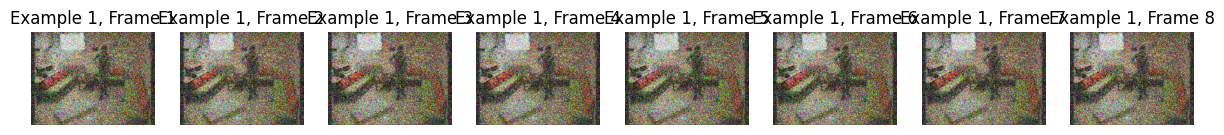

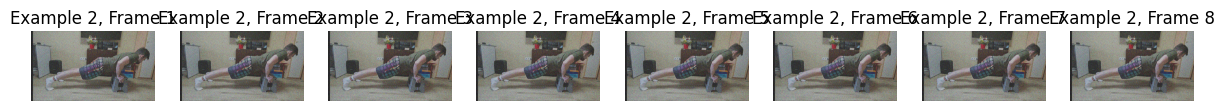

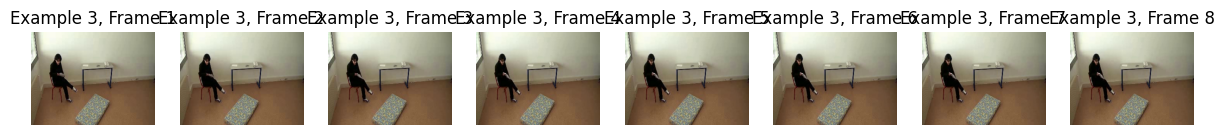

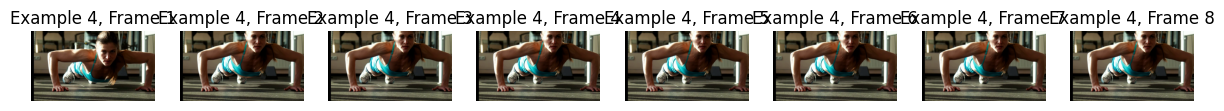

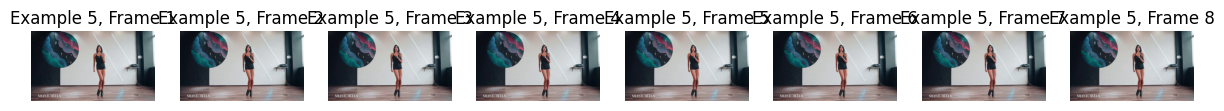

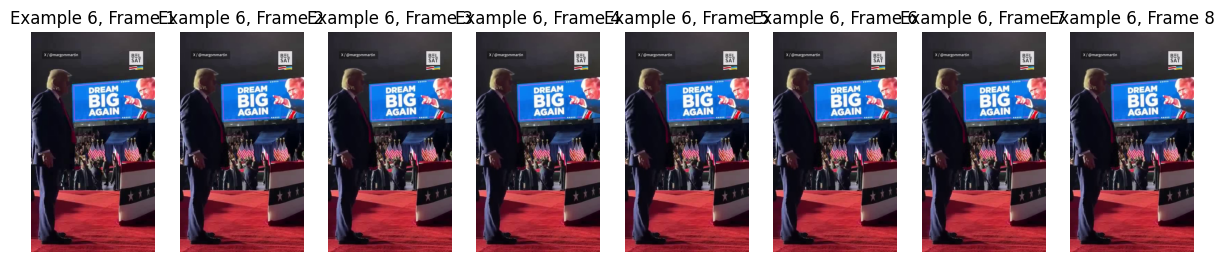

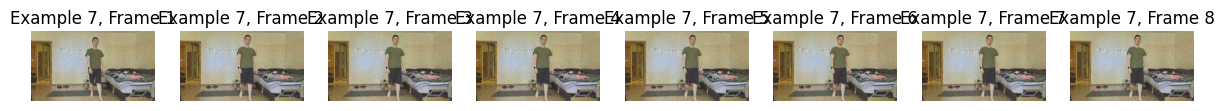

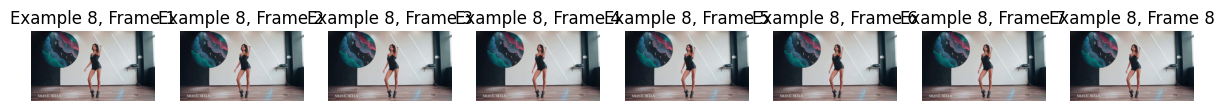

Пакет 2:
  Метки: tensor([2, 0, 1, 1, 0, 2, 1, 1])
  Форма батча: torch.Size([8, 1, 8, 3, 224, 224])
    Пример 1: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 2: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 3: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 4: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 5: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 6: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 7: Форма входных данных: torch.Size([1, 8, 3, 224, 224])
    Пример 8: Форма входных данных: torch.Size([1, 8, 3, 224, 224])


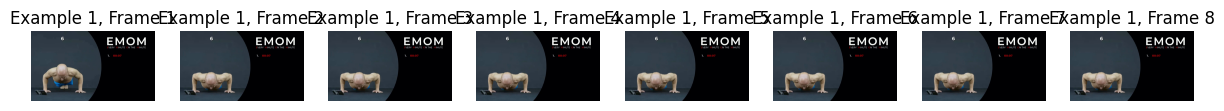

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [8]:
root_dir = r"C:\Users\jet\Desktop\видосы\8_0_frame"
model_name = "facebook/timesformer-base-finetuned-k400"
dataset = VideoDataset(root_dir, model_name, max_frames=8)
print("Размер датасета:", len(dataset))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
for batch_idx, (inputs_batch, labels_batch, frames_batch) in enumerate(dataloader):
    print(f"Пакет {batch_idx+1}:")
    print("  Метки:", labels_batch)
    print("  Форма батча:", inputs_batch["pixel_values"].shape)  
    
    # Проходим по каждому примеру в батче (всего 8 примеров)
    for i in range(inputs_batch["pixel_values"].size(0)):
        example_shape = inputs_batch["pixel_values"][i].shape   
        print(f"    Пример {i+1}: Форма входных данных: {example_shape}")
    
    # Если хотите визуализировать кадры для каждого примера, можно сделать так:
    import matplotlib.pyplot as plt
    for i, frames in enumerate(frames_batch):
        n_frames = len(frames)
        plt.figure(figsize=(15, 5))
        for j, frame in enumerate(frames):
            plt.subplot(1, n_frames, j+1)
            plt.imshow(frame)
            plt.title(f'Example {i+1}, Frame {j+1}')
            plt.axis('off')
        plt.show()

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Focal Loss для решения проблемы дисбаланса классов.
        :param alpha: Веса классов. Если None, все классы считаются равноважными.
        :param gamma: Фокусирующий параметр. Чем выше gamma, тем больше фокус на сложных примерах.
        :param reduction: Способ агрегации потерь ('none', 'mean', 'sum').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Применяем логит к целям
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # Вероятность предсказания правильного класса
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
def custom_collate(batch):
    # Фильтруем элементы, равные None
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        # Если в батче ничего не осталось, можно вернуть пустой батч или выбросить исключение
        return None  
    return default_collate(batch)


In [9]:
# Установка путей и параметров
model_name = "facebook/timesformer-base-finetuned-k400"
batch_size = 2
epochs = 5
learning_rate = 5e-5
max_frames = 8
num_workers = 0
save_path = "best_model.pt"
data_dir = r"C:\Users\jet\Desktop\видосы\8_0_frame"  # Замените на путь к вашим данным
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

if not os.path.isdir(train_dir):
    raise ValueError(f"Тренировочная директория не найдена: {train_dir}")
if not os.path.isdir(val_dir):
    raise ValueError(f"Валидационная директория не найдена: {val_dir}")

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    ToNumpy(),  # преобразует обратно в numpy массив
])


print("Загрузка конфигурации и модели...")
num_classes = 3
config = AutoConfig.from_pretrained(model_name, num_labels=num_classes)
model = AutoModelForVideoClassification.from_pretrained(
    model_name, 
    config=config, 
    ignore_mismatched_sizes=True
)

print("Сбор всех видеофайлов и меток из train_dir и val_dir...")
train_dataset = VideoDataset(root_dir=train_dir, model_name=model_name, max_frames=max_frames, transform=transform)
val_dataset = VideoDataset(root_dir=val_dir, model_name=model_name, max_frames=max_frames, transform=transform)

print("Разделение данных на тренировочную и валидационную выборки...")
train_files = train_dataset.video_files
train_labels = train_dataset.video_labels
val_files = val_dataset.video_files
val_labels = val_dataset.video_labels
class_to_idx = train_dataset.class_to_idx
class_names = train_dataset.class_names

# Вычисление весов классов для FocalLoss
label_counts = Counter(train_labels)
total_counts = sum(label_counts.values())
num_classes = len(class_names)

class_weights = []
for i in range(num_classes):
    count = label_counts.get(i, 0)
    if count > 0:
        class_weights.append(total_counts / (num_classes * count))
    else:
        class_weights.append(1.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Вес каждого класса: {class_weights}")

# Создание DataLoader
print("Создание DataLoader...")
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    collate_fn=custom_collate
)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Используемое устройство: {device}")
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

loss_fn = FocalLoss(alpha=class_weights, gamma=2, reduction='mean')

best_val_f1 = 0.0
# best_val_f1 = 0.0
for epoch in range(epochs):
    print(f"\nЭпоха {epoch + 1}/{epochs}")
    print("-" * 20)

    # ---- Обучение ----
    model.train()
    total_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    train_progress = tqdm(train_dataloader, desc="Обучение", leave=False)
    for step, batch in enumerate(train_progress):
        try:
            inputs, labels, frames_batch = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            inputs['pixel_values'] = inputs['pixel_values'].squeeze(1)

            outputs = model(**inputs)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            preds = torch.argmax(logits, dim=-1)
            all_train_preds.extend(preds.detach().cpu().numpy())
            all_train_labels.extend(labels.detach().cpu().numpy())

            train_progress.set_postfix({"loss": loss.item()})

            # Save model every 5 iterations
            if (step + 1) % 5000 == 0:
                model_save_path = f"model_epoch_{epoch + 1}_iter_{step + 1}.pt"
                torch.save(model.state_dict(), model_save_path)
                print(f"Модель сохранена на {model_save_path}")

        except Exception as e:
            print(f"Ошибка при обработке батча: {e}")
            continue

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train F1: {train_f1:.4f}")

    # ---- Валидация ----
    model.eval()
    total_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        val_progress = tqdm(val_dataloader, desc="Валидация", leave=False)
        for batch in val_progress:
            try:
                inputs, labels, frames_batch = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                inputs['pixel_values'] = inputs['pixel_values'].squeeze(1)

                outputs = model(**inputs)
                logits = outputs.logits

                loss = loss_fn(logits, labels)
                total_val_loss += loss.item()

                preds = torch.argmax(logits, dim=-1)
                all_val_preds.extend(preds.detach().cpu().numpy())
                all_val_labels.extend(labels.detach().cpu().numpy())
            except Exception as e:
                print(f"Ошибка при обработке батча валидации: {e}")
                continue

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), save_path)
        print(f"Сохранена лучшая модель с Val F1: {best_val_f1:.4f}")

print("\nОбучение завершено.")
print(f"Лучший Val F1: {best_val_f1:.4f}")


Загрузка конфигурации и модели...


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Сбор всех видеофайлов и меток из train_dir и val_dir...


C:\Users\jet\AppData\Local\Temp\ipykernel_32364\3255117783.py:47: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),


Разделение данных на тренировочную и валидационную выборки...
Вес каждого класса: tensor([1.9495, 0.5493, 1.5001], device='cuda:0')
Создание DataLoader...
Используемое устройство: cuda

Эпоха 1/5
--------------------


Обучение:  31%|███████████████▉                                   | 5000/15990 [58:55<2:36:52,  1.17it/s, loss=0.00245]

Модель сохранена на model_epoch_1_iter_5000.pt


Обучение:  63%|██████████████████████████████                  | 10000/15990 [1:58:41<1:25:51,  1.16it/s, loss=5.22e-8]

Модель сохранена на model_epoch_1_iter_10000.pt


Обучение:  94%|████████████████████████████████████████████████▊   | 15000/15990 [2:58:32<14:05,  1.17it/s, loss=0.129]

Модель сохранена на model_epoch_1_iter_15000.pt


Train Loss: 0.1103 | Train Acc: 0.9144 | Train F1: 0.9172


Val Loss: 1.2287 | Val Acc: 0.4635 | Val F1: 0.4643
Сохранена лучшая модель с Val F1: 0.4643

Эпоха 2/5
--------------------


Обучение:  31%|████████████████▌                                    | 5000/15990 [57:50<2:27:46,  1.24it/s, loss=0.568]

Модель сохранена на model_epoch_2_iter_5000.pt


Обучение:  63%|█████████████████████████████▍                 | 10000/15990 [1:55:36<1:21:46,  1.22it/s, loss=0.000315]

Модель сохранена на model_epoch_2_iter_10000.pt


Обучение:  94%|██████████████████████████████████████████████▉   | 15000/15990 [2:53:19<13:03,  1.26it/s, loss=1.66e-5]

Модель сохранена на model_epoch_2_iter_15000.pt


Train Loss: 0.0445 | Train Acc: 0.9634 | Train F1: 0.9640


Val Loss: 1.5361 | Val Acc: 0.3372 | Val F1: 0.3233

Эпоха 3/5
--------------------


Обучение:  31%|███████████████▉                                   | 5000/15990 [56:52<2:26:36,  1.25it/s, loss=1.76e-6]

Модель сохранена на model_epoch_3_iter_5000.pt


Обучение:  47%|██████████████████████▊                          | 7445/15990 [1:25:06<5:40:36,  2.39s/it, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|██████████████████████▊                          | 7447/15990 [1:25:06<3:03:16,  1.29s/it, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|██████████████████████▊                          | 7448/15990 [1:25:06<2:17:17,  1.04it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|██████████████████████▊                          | 7449/15990 [1:25:07<1:47:57,  1.32it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|██████████████████████▊                          | 7450/15990 [1:25:07<1:30:33,  1.57it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|██████████████████████▊                          | 7451/15990 [1:25:07<1:12:38,  1.96it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|██████████████████████▊                          | 7452/15990 [1:25:08<1:04:15,  2.21it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|██████████████████████▊                          | 7453/15990 [1:25:08<1:04:09,  2.22it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7454/15990 [1:25:08<58:27,  2.43it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7455/15990 [1:25:09<58:50,  2.42it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7456/15990 [1:25:09<57:03,  2.49it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7457/15990 [1:25:09<51:31,  2.76it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7458/15990 [1:25:10<48:18,  2.94it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7460/15990 [1:25:10<38:58,  3.65it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7461/15990 [1:25:10<38:44,  3.67it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7462/15990 [1:25:11<43:41,  3.25it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7463/15990 [1:25:11<39:44,  3.58it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7464/15990 [1:25:11<36:31,  3.89it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7466/15990 [1:25:12<34:50,  4.08it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7467/15990 [1:25:12<36:31,  3.89it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7468/15990 [1:25:12<40:35,  3.50it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7470/15990 [1:25:13<34:11,  4.15it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7472/15990 [1:25:13<30:11,  4.70it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7474/15990 [1:25:13<25:10,  5.64it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7475/15990 [1:25:14<31:00,  4.58it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7476/15990 [1:25:14<32:44,  4.33it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7477/15990 [1:25:14<37:06,  3.82it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7479/15990 [1:25:15<30:10,  4.70it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7480/15990 [1:25:15<32:54,  4.31it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7481/15990 [1:25:15<32:57,  4.30it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7483/15990 [1:25:16<31:48,  4.46it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▊                           | 7485/15990 [1:25:16<27:12,  5.21it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7487/15990 [1:25:16<28:36,  4.95it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7489/15990 [1:25:17<29:04,  4.87it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7490/15990 [1:25:17<26:18,  5.39it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7491/15990 [1:25:17<27:58,  5.06it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7493/15990 [1:25:18<25:02,  5.65it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7495/15990 [1:25:18<24:47,  5.71it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7497/15990 [1:25:18<24:35,  5.76it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7499/15990 [1:25:19<25:25,  5.57it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7500/15990 [1:25:19<29:26,  4.81it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7502/15990 [1:25:19<29:21,  4.82it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7504/15990 [1:25:20<24:03,  5.88it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7505/15990 [1:25:20<25:14,  5.60it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7507/15990 [1:25:20<27:44,  5.10it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7509/15990 [1:25:21<25:49,  5.47it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7511/15990 [1:25:21<24:22,  5.80it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7512/15990 [1:25:21<26:43,  5.29it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7513/15990 [1:25:21<28:53,  4.89it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7514/15990 [1:25:22<29:16,  4.83it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7516/15990 [1:25:22<31:37,  4.47it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7518/15990 [1:25:23<28:43,  4.92it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7519/15990 [1:25:23<26:06,  5.41it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7520/15990 [1:25:23<30:32,  4.62it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7521/15990 [1:25:23<33:22,  4.23it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7522/15990 [1:25:23<32:08,  4.39it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|███████████████████████▉                           | 7524/15990 [1:25:24<28:07,  5.02it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7525/15990 [1:25:24<31:12,  4.52it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7527/15990 [1:25:25<30:35,  4.61it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7528/15990 [1:25:25<32:23,  4.35it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7530/15990 [1:25:25<27:26,  5.14it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7531/15990 [1:25:25<26:54,  5.24it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7533/15990 [1:25:26<24:27,  5.76it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7534/15990 [1:25:26<27:12,  5.18it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7536/15990 [1:25:26<26:12,  5.38it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7537/15990 [1:25:26<27:21,  5.15it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7538/15990 [1:25:27<30:55,  4.56it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7539/15990 [1:25:27<30:52,  4.56it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7540/15990 [1:25:27<30:53,  4.56it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7542/15990 [1:25:27<27:13,  5.17it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7544/15990 [1:25:28<26:17,  5.36it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7545/15990 [1:25:28<30:29,  4.62it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7547/15990 [1:25:29<27:18,  5.15it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7548/15990 [1:25:29<28:11,  4.99it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7549/15990 [1:25:29<30:41,  4.58it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7551/15990 [1:25:29<28:34,  4.92it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7552/15990 [1:25:30<26:33,  5.30it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7553/15990 [1:25:30<28:33,  4.92it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7554/15990 [1:25:30<29:17,  4.80it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7555/15990 [1:25:30<31:48,  4.42it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7557/15990 [1:25:31<31:01,  4.53it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7558/15990 [1:25:31<30:51,  4.55it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7560/15990 [1:25:31<27:39,  5.08it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7561/15990 [1:25:32<31:32,  4.45it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████                           | 7562/15990 [1:25:32<34:10,  4.11it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7564/15990 [1:25:32<29:39,  4.73it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7566/15990 [1:25:33<29:14,  4.80it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7567/15990 [1:25:33<30:00,  4.68it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7569/15990 [1:25:33<29:38,  4.74it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7571/15990 [1:25:34<26:04,  5.38it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7573/15990 [1:25:34<24:20,  5.76it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7575/15990 [1:25:34<23:46,  5.90it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7577/15990 [1:25:35<23:21,  6.00it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7578/15990 [1:25:35<26:30,  5.29it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7579/15990 [1:25:35<30:41,  4.57it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7580/15990 [1:25:35<32:03,  4.37it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7582/15990 [1:25:36<31:38,  4.43it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7584/15990 [1:25:36<26:37,  5.26it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7585/15990 [1:25:37<35:38,  3.93it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7586/15990 [1:25:37<37:31,  3.73it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7588/15990 [1:25:37<35:53,  3.90it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7589/15990 [1:25:38<37:43,  3.71it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7590/15990 [1:25:38<37:28,  3.74it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7591/15990 [1:25:38<35:39,  3.93it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7593/15990 [1:25:39<32:03,  4.37it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7594/15990 [1:25:39<28:40,  4.88it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  47%|████████████████████████▏                          | 7595/15990 [1:25:39<30:18,  4.62it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▏                          | 7596/15990 [1:25:39<32:39,  4.28it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▏                          | 7597/15990 [1:25:40<35:22,  3.95it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▏                          | 7598/15990 [1:25:40<34:42,  4.03it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▏                          | 7599/15990 [1:25:40<39:35,  3.53it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▏                          | 7601/15990 [1:25:41<33:39,  4.15it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▏                          | 7602/15990 [1:25:41<29:31,  4.73it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▏                          | 7603/15990 [1:25:41<32:32,  4.30it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7605/15990 [1:25:41<28:40,  4.87it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7606/15990 [1:25:42<31:22,  4.45it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7607/15990 [1:25:42<32:12,  4.34it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7609/15990 [1:25:42<28:09,  4.96it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7610/15990 [1:25:42<25:06,  5.56it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7611/15990 [1:25:43<26:53,  5.19it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7613/15990 [1:25:43<27:22,  5.10it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7616/15990 [1:25:43<20:45,  6.72it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7618/15990 [1:25:44<22:10,  6.29it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7619/15990 [1:25:44<23:09,  6.02it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7621/15990 [1:25:44<24:52,  5.61it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7623/15990 [1:25:45<27:43,  5.03it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7624/15990 [1:25:45<28:51,  4.83it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7625/15990 [1:25:45<30:30,  4.57it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Обучение:  48%|████████████████████████▎                          | 7627/15990 [1:25:46<28:31,  4.89it/s, loss=3.52e-7]

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Ошибка при обработке батча: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.




KeyboardInterrupt


KeyboardInterrupt

